In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import digamma 
from scipy.stats import gamma,norm

## prior setting
Let $\left(\sigma^2 \right)^{-1} = \tau$ Then,
$$
\begin{align*}
y_i | \mu, \tau &\sim N(\mu, \tau^{-1})\\
\tau &\sim Gamma(a_0,b_0)\\
\mu | \tau &\sim N(0, (\tau/k)^{-1})
\end{align*}
$$
Thus
$$
\begin{align*}
p(\mu,\tau | Y) = \frac{p(\mu,\tau)p(Y|\mu,\tau)}{p(Y)} = \frac{p(\mu|\tau)p(\tau)p(Y|\mu,\tau)}{p(Y)}
\end{align*}
$$

# (a) Derive MF variational distribution of $(\mu, \tau)$ and ELBO
Let $\theta = (a_0,b_0,k), p=p(\mu,\tau|Y,\theta)$ and $q=q(\mu,\tau)$
$$
p(\mu,\tau|Y,\theta) \approx q(\mu,\tau) = q_1(\mu)q_2(\tau)
$$
Thus, mean-field variational distribution is 
$$
q(\mu,\tau) = q_1(\mu|t,u)q_2(\tau|v,w)
$$
where $q_1 \sim N(t,u^{-1})$ and $q_2 \sim Gamma(v,w)$, variational parameters $\lambda = (t,u,v,w)$. ELBO is
$$
\begin{align*}
ELBO(\lambda) =&E_q[\log p(\mu,\tau,Y)|\lambda] -E_q[\log q(\mu,\tau)|\lambda]\\
=&\sum_{i=1}^{n}E_q[\log p(y_i|\mu,\tau)|\lambda] + E_q[\log p(\mu|\tau)|t,u] + E_q[\log p(\tau)|w,v]\\
&-E_{q_1}[log q_1(\mu|t,u)|t,u] -E_{q_2}[log q_2(\tau)|v,w]
\end{align*}
$$

# (b) derive the coordinate descent algorithm

$$
\begin{align*}
\log q_1^*(\mu) &\propto E_{q_2}\left[ \log p(\mu,\tau,Y)\right] \propto  E_{q_2}\left[ \log p(Y|\mu,\tau) + \log p(\mu|\tau)\right]\\
&\propto -\frac{1}{2} E_{q_2}[\tau] \cdot \sum_{i=1}^{n}(y_i - \mu)^2 - \frac{E_{q_2}[\tau]}{2k}\mu^2 \\
&\propto -\frac{1}{2} \left[E_{q_2}[\tau]\left(n + \frac{1}{k}\right)\mu^2 -2E_{q_2}[\tau]\mu\sum_{i=1}^{n}y_i \right]
\end{align*}
$$
Thus
$$
t = \frac{k\sum_{i=1}^{n}y_i}{nk + 1} , u =\frac{E_{q2}[\tau](nk + 1)}{k}
$$
as $q_1^*(\mu) \sim N(t,u^{-1})$
$$
\begin{align*}
E_{q_1}[\mu] &= t = \frac{k\sum_{i=1}^{n}y_i}{nk + 1}\\
E_{q_1}[\mu^2] &= u^{-1} + t^2 = \left[\frac{k}{E_{q2}[\tau](nk + 1)}\right]  + \left[\frac{k\sum_{i=1}^{n}y_i}{nk + 1}\right]^2
\end{align*}
$$
where $E_{q2}[\tau] = v/w$

$$
\begin{align*}
\log q_2^*(\tau) &\propto E_{q_1}\left[ \log p(\mu,\tau,Y)\right] \propto  E_{q_1}\left[ \log p(Y|\mu,\tau) + \log p(\mu|\tau) + \log p(\tau)\right]\\
&\propto (a_0-1)\log\tau - b_0 \tau + \frac{n}{2}\log\tau - \frac{1}{2}\tau E_{q_1}\left[\sum_{i=1}^{n}(y_i - \mu)^2 \right] + \frac{1}{2}\log \tau -\frac{\tau}{2k}E_{q_1}\left[\mu^2\right]\\
&\propto \log(\tau)\left(a_0-1 +\frac{n+1}{2}\right) - \tau \left(b_0 + \frac{1}{2}  E_{q_1}\left[\sum_{i=1}^{n}(y_i - \mu)^2 \right] + \frac{1}{2k}E_{q_1}\left[\mu^2\right]\right)
\end{align*}
$$
Thus
$$
v = a_0 +\frac{n+1}{2} , w =b_0 + \frac{1}{2}  E_{q_1}\left[\sum_{i=1}^{n}(y_i - \mu)^2 \right] + \frac{1}{2k}E_{q_1}\left[\mu^2\right]
$$
where,
$$
 E_{q_1}\left[\sum_{i=1}^{n}(y_i - \mu)^2 \right] = \sum y_i^2 - 2\sum y_i E[\mu] + E[\mu^2]
$$
$q_2^*(\tau) \sim Gamma(v,w)$

# (c) write down python code

input data

In [2]:
Y = np.array([1.64,1.70,1.72,1.74,1.82,1.82,1.82,
              1.90,2.08,1.78,1.86,1.96,1.96,2.00,2.00])

setting the initail value

In [3]:
def mfvb(Y,maxiter = 100):
    a_0=2
    b_0=60
    k=2
    n= len(Y)
    expected_mu = 0
    expected_mu2 = 1

    v = a_0 +(n+1)/2
    param_out=[]
    i=0
    while i<maxiter:
        w = b_0 + 0.5*((Y**2).sum() -2 *Y.sum() * expected_mu 
                       + expected_mu2) + expected_mu2/(2*k)
        expected_tau = v/w
        t = (k*Y.sum())/(n*k+1)
        u = (expected_tau * (n*k+1))/k
        expected_mu = t
        expected_mu2 = 1/u + t**2
        param_out.append([v,w,t,u])
        i= i+1
        if i>1:
            if param_out[-1] == param_out[-2]:
                break
    out = pd.DataFrame(param_out)
    out.columns = ['v','w','t','u']
    return(out)

In [4]:
mfvb(Y)

,v,w,t,u
0,10.0,86.625200,1.793548,1.789318
1,10.0,38.846321,1.793548,3.990082
2,10.0,38.615133,1.793548,4.013970
3,10.0,38.614014,1.793548,4.014087
4,10.0,38.614009,1.793548,4.014087
5,10.0,38.614009,1.793548,4.014087
6,10.0,38.614009,1.793548,4.014087
7,10.0,38.614009,1.793548,4.014087
8,10.0,38.614009,1.793548,4.014087


In [5]:
ksigma2 = 1/4.014087
sigma2 = ksigma2/2
print(ksigma2,sigma2)

0.24912265229926506 0.12456132614963253


$$
\begin{align*}
q_2(\tau) &\sim Gamma(10,38.614009)\\
q_1(\mu) &\sim N(	1.793548, 0.249123)
\end{align*}
$$

# (d) draw contour of the target posterior distribution and compare it with MFVB

## VI Contour

$$
\begin{align*}
q_2(\tau) &\sim Gamma(10,38.614009)\\
q_1(\mu) &\sim N(	1.793548, 0.249123)
\end{align*}
$$

In [6]:
def q(mu,tau):
    out = gamma.pdf(tau,a = 10,scale = 1/38.614009)*\
          norm.pdf(mu,loc = 1.793548,
                   scale = np.sqrt(0.249123))
    return(out)

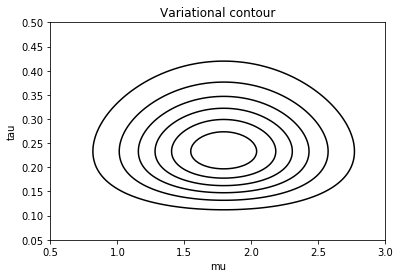

In [7]:
tau = np.linspace(0.05, 0.5, 100)
mu = np.linspace(0.5, 3, 100)

Mu, Tau = np.meshgrid(mu, tau)
vi = q(Mu, Tau)
plt.contour( Mu,Tau, vi, colors='black')
plt.title('Variational contour')
plt.xlabel('mu')
plt.ylabel('tau')
plt.show()

## Posterior contour
$$
\begin{align*}
p(\mu, \tau|Y) &\propto   p(\mu,\tau,Y) \propto    p(Y|\mu,\tau) p(\mu|\tau)  p(\tau)\\
\end{align*}
$$
Thus

where $a_0=2,b_0=60$ and $k=2$

In [8]:
def p(mu,tau,Y):
    out = np.prod(norm.pdf(Y,loc = mu,
                   scale = np.sqrt(tau**(-1))))*\
    norm.pdf(mu,loc = 0,
             scale = np.sqrt(2*(tau**(-1))))*\
    gamma.pdf(tau,a = 2,scale = 1/60)
    return(out)

In [9]:
post = np.zeros([100,100])
for i in range(100):
    for j in range(100):
        post[i,j] = p(mu[i], tau[j],Y)

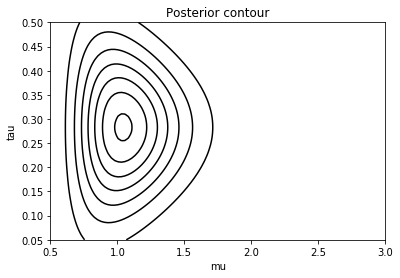

In [10]:
plt.contour(Mu, Tau, post, colors='black')
plt.title('Posterior contour')
plt.xlabel('mu')
plt.ylabel('tau')
plt.show()

## Compare

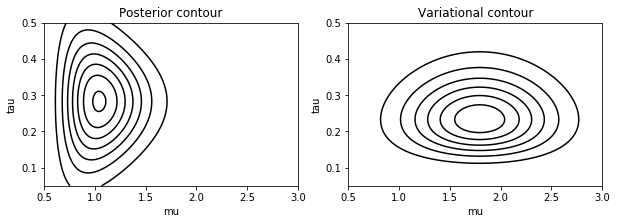

In [17]:
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.contour(Mu, Tau, post, colors='black')
plt.xlabel('mu')
plt.ylabel('tau')
plt.title('Posterior contour')
plt.subplot(1,2,2)
plt.contour(Mu,Tau, vi, colors='black')
plt.xlabel('mu')
plt.ylabel('tau')
plt.title('Variational contour')
plt.show()

It seems that mean-field vairational distribution overestimate variance of $\mu$ and underestimate variance of $\tau$